In [13]:
import duckdb
con = duckdb.connect(':memory:')

In [14]:
sql = """
CREATE TABLE bitcoin AS
    FROM 'bitcoin_2024-01-01_2024-09-27.csv'
"""
con.execute(sql)

In [15]:
sql = """
select * from bitcoin order by Start limit 10
"""
con.sql(sql)

┌────────────┬────────────┬──────────┬──────────┬──────────┬──────────┬────────────────────┬───────────────────┐
│   Start    │    End     │   Open   │   High   │   Low    │  Close   │       Volume       │    Market Cap     │
│    date    │    date    │  double  │  double  │  double  │  double  │       double       │      double       │
├────────────┼────────────┼──────────┼──────────┼──────────┼──────────┼────────────────────┼───────────────────┤
│ 2024-01-01 │ 2024-01-02 │ 42276.34 │ 44122.03 │ 42227.99 │ 44122.03 │  25446134905.26736 │ 838250699610.9688 │
│ 2024-01-02 │ 2024-01-03 │  44179.5 │ 45846.21 │  44179.5 │ 44957.63 │  46593616092.15278 │ 885906624909.5868 │
│ 2024-01-03 │ 2024-01-04 │ 44944.83 │ 45474.95 │ 40931.46 │ 42818.03 │  99124375067.69098 │ 860210389676.8438 │
│ 2024-01-04 │ 2024-01-05 │ 42845.26 │ 44664.55 │ 42635.44 │ 44188.15 │ 163905349005.13196 │ 851366855527.3577 │
│ 2024-01-05 │ 2024-01-06 │ 44168.03 │ 44229.51 │ 43142.74 │ 44112.11 │  142446432011.0521 │  85

### Faster Signals: 

Smaller values for N1 and N2 can result in faster signals but may also generate more false signals.

### Smoothing Signals: 

Increasing N1 and N2 can smooth out the signals but may cause delays in reacting to price changes.

### Experimentation: 

Traders often experiment with different combinations of N1 and N2 to find the settings that work best for their specific trading style and preferences.

Step 1: Calculate the Short-term EMA, N1=12

In [ ]:
N1=12

sql = """
SELECT
    *,
    AVG(Close) OVER (ORDER BY Start ROWS BETWEEN 11 PRECEDING AND CURRENT ROW) AS ema_short
FROM
    bitcoin;
"""
con.sql(sql)

Step 2: Calculate the Long-term EMA, N2=26

In [ ]:
N2=26

sql = """
SELECT
    *,
    AVG(Close) OVER (ORDER BY Start ROWS BETWEEN 25 PRECEDING AND CURRENT ROW) AS ema_long
FROM
    bitcoin;
"""
con.sql(sql)

Step 3: Calculate the MACD Line

Subtract the Long-term EMA from the Short-term EMA to get the MACD Line

In [ ]:
sql = """
SELECT *, ema_short - ema_long as macd_line
from (
    SELECT
        *,
        AVG(Close) OVER (ORDER BY Start ROWS BETWEEN 11 PRECEDING AND CURRENT ROW) AS ema_short,
        AVG(Close) OVER (ORDER BY Start ROWS BETWEEN 25 PRECEDING AND CURRENT ROW) AS ema_long
    FROM
        bitcoin
)
"""
con.sql(sql)

Step 4: Calculate the Signal Line (9-day EMA of MACD Line)

In [ ]:
sql = """
SELECT *, AVG(macd_line) OVER (ORDER BY Start ROWS BETWEEN 8 PRECEDING AND CURRENT ROW) AS signal_line
FROM (
    SELECT *, ema_short - ema_long as macd_line
    from (
        SELECT
            *,
            AVG(Close) OVER (ORDER BY Start ROWS BETWEEN 11 PRECEDING AND CURRENT ROW) AS ema_short,
            AVG(Close) OVER (ORDER BY Start ROWS BETWEEN 25 PRECEDING AND CURRENT ROW) AS ema_long
        FROM
            bitcoin
    )
)
"""
con.sql(sql)

Step 5: Calculate the MACD Histogram

Subtract the Signal Line from the MACD Line to obtain the MACD Histogram

In [16]:
sql = """
SELECT *, macd_line - signal_line as histogram
from (
    SELECT *, AVG(macd_line) OVER (ORDER BY Start ROWS BETWEEN 8 PRECEDING AND CURRENT ROW) AS signal_line
    FROM (
        SELECT *, ema_short - ema_long as macd_line
        from (
            SELECT
                *,
                AVG(Close) OVER (ORDER BY Start ROWS BETWEEN 11 PRECEDING AND CURRENT ROW) AS ema_short,
                AVG(Close) OVER (ORDER BY Start ROWS BETWEEN 25 PRECEDING AND CURRENT ROW) AS ema_long
            FROM
                bitcoin
        )
    )
)
"""
result = con.sql(sql)
resultdf = result.fetchdf()

In [17]:
sql_csv = f'COPY ({sql}) TO macd_result.csv (HEADER, DELIMITER ",")'
con.execute(sql_csv)

Plot MACD

In [17]:
data.head()

,End,Open,High,Low,Close,Volume,Market Cap,ema_short,ema_long,macd_line,signal_line,histogram
Start,,,,,,,,,,,,
2023-09-23,2023-09-24,26580.10,26632.75,26524.90,26580.66,2.748552e+10,5.180460e+11,26580.660000,26580.660000,0.0,0.0,0.0
2023-09-24,2023-09-25,26575.97,26708.73,26238.82,26254.11,2.055885e+10,5.177088e+11,26417.385000,26417.385000,0.0,0.0,0.0
2023-09-25,2023-09-26,26251.64,26419.98,26029.07,26308.45,2.972998e+10,5.108293e+11,26381.073333,26381.073333,0.0,0.0,0.0
2023-09-26,2023-09-27,26304.75,26386.51,26124.07,26217.38,3.080141e+10,5.116849e+11,26340.150000,26340.150000,0.0,0.0,0.0
2023-09-27,2023-09-28,26214.89,26808.54,26172.50,26368.04,2.848609e+10,5.133264e+11,26345.728000,26345.728000,0.0,0.0,0.0


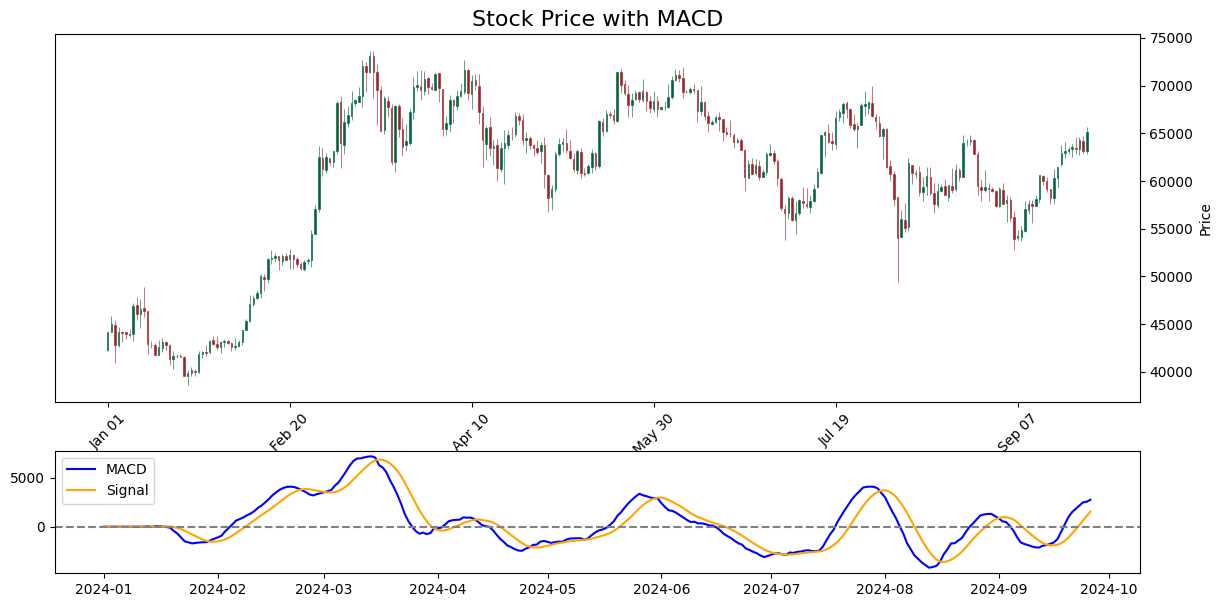

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplfinance as mpf  # For candlestick chart

data = resultdf.set_index('Start')

macd = data['macd_line']
signal = data['signal_line']

# Plotting
fig, axs = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, figsize=(14, 7))

# Candlestick chart
# mpf.plot(data, type='candle', ax=axs[0], volume=False, style='charles', title='Stock Price with MACD')

# Candlestick chart with title
mpf.plot(data, type='candle', ax=axs[0], volume=False, style='charles')
axs[0].set_title('Stock Price with MACD', fontsize=16)  # Set title on the candlestick chart subplot

# MACD plot
axs[1].plot(data.index, macd, label='MACD', color='blue')
axs[1].plot(data.index, signal, label='Signal', color='orange')
axs[1].axhline(0, linestyle='--', color='gray')  # Zero line
axs[1].legend()

plt.show()